<div>
    <h1 style="color:blue;"align="center"> SCALER </h1> 
</div>

<h3 align="center">Unsupervised Method</h3>


## Business Problem
Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.


You are working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. 

You are provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features. Ideally, these clusters should have similar characteristics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px

from scipy import stats
import statsmodels.api as sm

sns.set(style="whitegrid")
%matplotlib inline

In [2]:
from datetime import date
import re

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.MAX_COLUMN',None)

**IMPORT DATASET**

In [3]:
df = pd.read_csv("../data/scaler_clustering.csv",index_col='Unnamed: 0')
df.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
89619,ohqtxn ogrhnxgzo xzw,ef073d59ee3f21565832ab1efa86a76cdb1fb309448b5d...,2014.0,1600000,Backend Engineer,2019.0
169320,zvz,23b81a32a0a76e40c945e5eed202d7d9c5a3f8b1519eba...,2009.0,3000000,NaN,2021.0
185174,ovbohzs trtwnqgzxwo,3e336844d017a7cea278e3d46252b16b0a16272f54e303...,2002.0,65000,NaN,2017.0
19435,owyggr,8689080ccdecfe6a33e9c61b00144a663fbd13ec2ffaaa...,2018.0,400000,Other,2020.0
190767,pttrxt exnkstqvra,d4084503db56788d313066630262df689ee35c74d29963...,2020.0,900000,NaN,2019.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205843 entries, 0 to 206922
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205799 non-null  object 
 1   email_hash        205843 non-null  object 
 2   orgyear           205757 non-null  float64
 3   ctc               205843 non-null  int64  
 4   job_position      153281 non-null  object 
 5   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 11.0+ MB


In [5]:
pd.DataFrame(
    [df.isna().sum(),(df.isna().sum() / len(df)).mul(100) ]
).T.rename(columns={0:'# of missing values',1:'percentage of NA values'})

,# of missing values,percentage of NA values
company_hash,44.0,0.021376
email_hash,0.0,0.000000
orgyear,86.0,0.041779
ctc,0.0,0.000000
job_position,52562.0,25.534995
ctc_updated_year,0.0,0.000000


In [6]:
# Reduentent Records
df.duplicated().sum()

33

`33` **reduentent records are present**

In [7]:
duplicate_data = df.loc[df.duplicated()]

df.drop_duplicates(inplace=True)

In [8]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company_hash,205766,37299,nvnv wgzohrnvzwj otqcxwto,8337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
email_hash,205810,153443,bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orgyear,205724.0,NaN,NaN,NaN,2014.882284,63.576199,0.0,2013.0,2016.0,2018.0,20165.0
ctc,205810.0,NaN,NaN,NaN,2271853.647053,11801845.290045,2.0,530000.0,950000.0,1700000.0,1000150000.0
job_position,153263,1017,Backend Engineer,43546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctc_updated_year,205810.0,NaN,NaN,NaN,2019.628279,1.325188,2015.0,2019.0,2020.0,2021.0,2021.0


In [9]:
df.nunique()

company_hash         37299
email_hash          153443
orgyear                 77
ctc                   3360
job_position          1017
ctc_updated_year         7
dtype: int64

In [10]:
df.drop('email_hash',inplace=True,axis=1)

**email be unique to the person which tends to make every data point as cluster as unique**

## Data Pre-processing

##### company_hash feature

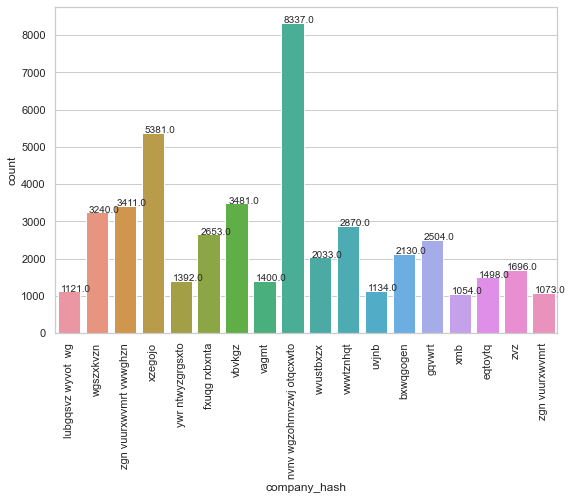

In [11]:
plt.figure(figsize=(9,6))
ax = sns.countplot(
    data = df.loc[ df.company_hash.isin( 
            df.company_hash.value_counts(dropna=False)[df.company_hash.value_counts(dropna=False).values>1000].index)],
    x='company_hash')
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.2))
plt.xticks(rotation=90)
plt.show()

##### org_year

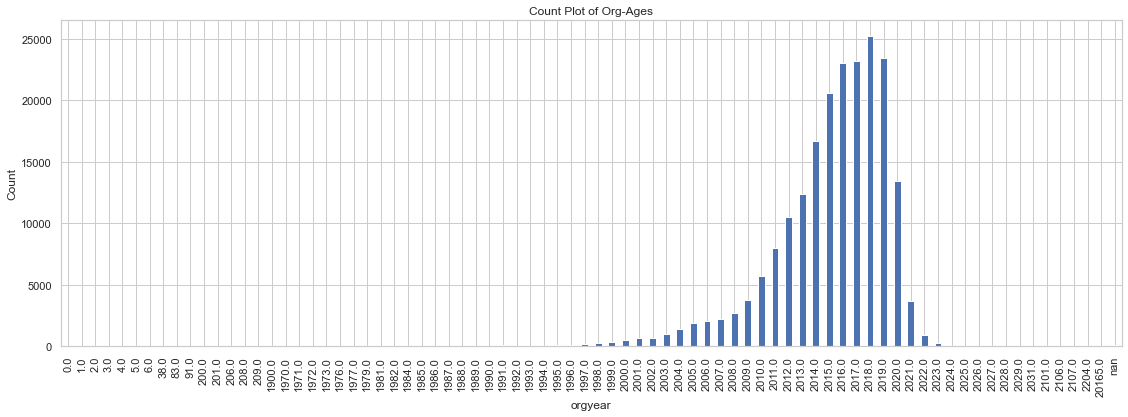

In [12]:
plt.figure(figsize=(19,6))
df.orgyear.value_counts(dropna=False).sort_index().plot(kind="bar")
plt.xlabel("orgyear")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Count Plot of Org-Ages",fontweight=15,fontsize="large")
plt.show()

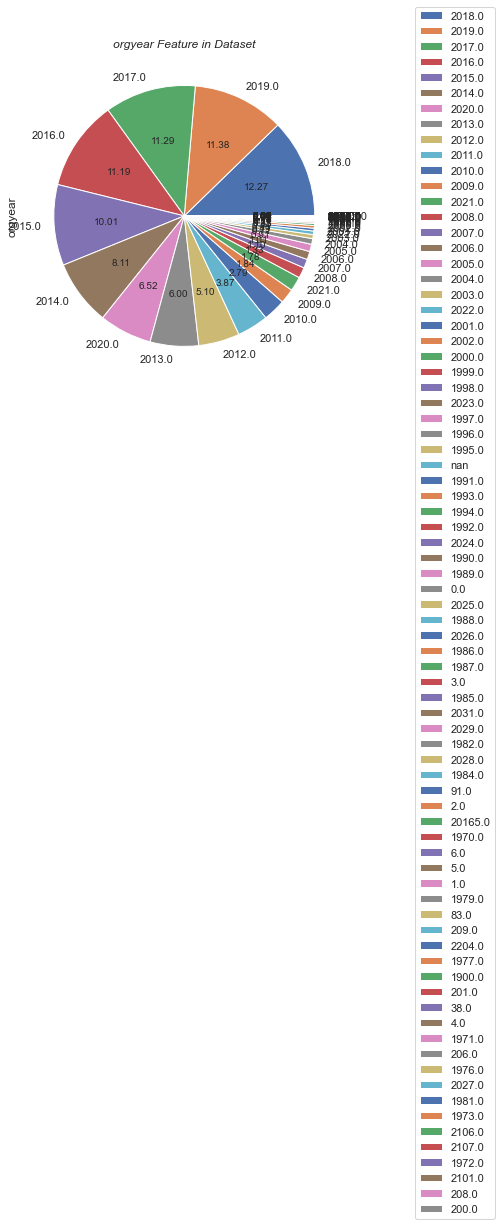

In [13]:
plt.figure(figsize=(9,6))
df['orgyear'].value_counts(dropna=False).plot(kind='pie',autopct="%0.2f")
plt.legend()
plt.title("orgyear Feature in Dataset",fontdict={"style":"italic"})
plt.legend(bbox_to_anchor=(1.0,1.0),\
    bbox_transform=plt.gcf().transFigure)
plt.show()

`Inference`: **as you see above some orgyears are irrelevant we'll get rid in feature engineering step**

##### ctc feature

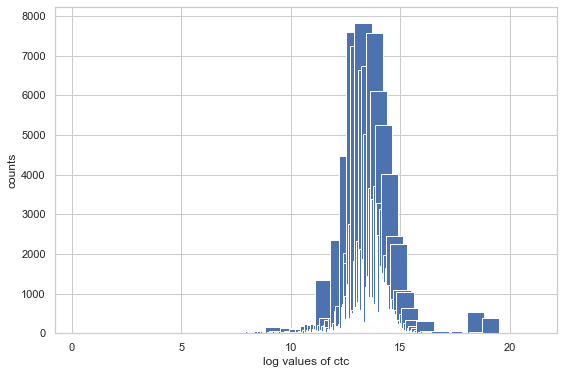

In [14]:
x_axis = df.ctc.value_counts(dropna=False).sort_index().index
y_axis = df.ctc.value_counts(dropna=False).sort_index().values


plt.figure(figsize=(9,6))
# Follows log-normall distribution
plt.bar(np.log(x_axis),y_axis)
plt.xlabel('log values of ctc')
plt.ylabel('counts')
plt.show()

`Inference`: **superprisingly salary follows log-normal distribution** or we can use box-mulllar transformation

In [15]:
df['log_ctc'] = np.log(df.ctc)

In [16]:
df.log_ctc.describe().T

count    205810.000000
mean         13.745907
std           1.055896
min           0.693147
25%          13.180632
50%          13.764217
75%          14.346139
max          20.723416
Name: log_ctc, dtype: float64

`Inferences`: **proof for normal curve**

In [17]:
mu,sig = df.log_ctc.describe()[['mean','std']]

print(f" mean of log-normal ctc: {mu} and standard deviation of log-normal ctc:{sig} ")

 mean of log-normal ctc: 13.745907493206696 and standard deviation of log-normal ctc:1.0558960653149354 


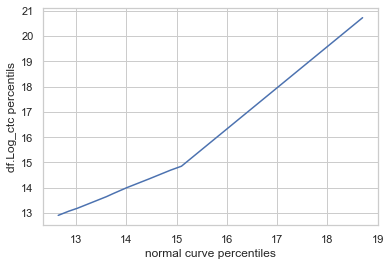

In [18]:
log_normall = stats.norm(mu,sig)

sns.lineplot(
    x=np.percentile(log_normall.rvs(205693),[15,20,25,45,50,60,75,86,90,100]),
    y=np.percentile(df.log_ctc,[15,20,25,45,50,60,75,86,90,100])
)
# plt.plot([0,1],[0,1],'r--')
plt.xlabel('normal curve percentiles')
plt.ylabel('df.Log_ctc percentils')
plt.show()

`Inference`: It's close to striaght line so we are good to go

In [19]:
q3, q1 = np.percentile(df.log_ctc, [75 ,25])
iqr    = q3-q1

print(f'''
quantile-1 for log-ctc {q1} and 
quantile-3 for log-ctc {q3} and 
interquantile of log-ctc {iqr}or {(q1- (1.5*iqr)), (q3+(1.5*iqr))}''')


quantile-1 for log-ctc 13.180632285528304 and 
quantile-3 for log-ctc 14.346138809026444 and 
interquantile of log-ctc 1.1655065234981397or (11.432372500281094, 16.094398594273652)


`Inference`: We remove records based on Log-CTC IQR methods

##### ctc_updated_year

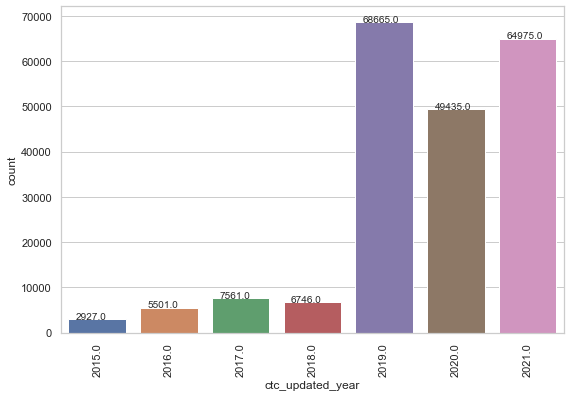

In [20]:
plt.figure(figsize=(9,6))
ax = sns.countplot(
    x =  df['ctc_updated_year'])
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.2))
plt.xticks(rotation=90)
plt.show()

##### job_position feature

In [21]:
df.job_position.value_counts(dropna=False)

NaN                               52547
Backend Engineer                  43546
FullStack Engineer                24711
Other                             18071
Frontend Engineer                 10417
                                  ...  
ayS                                   1
Principal Product Engineer            1
Senior Director of Engineering        1
Seller Support Associate              1
Android Application developer         1
Name: job_position, Length: 1018, dtype: int64

In [22]:
def remove_special (string):
    new_string=re.sub('[^A-Za-z ]+', '', string)
    return new_string

In [23]:
#what happens here: remove spl keyword from word
mystring='\tAirtel\\\\&&**() X */$@ Labs'
re.sub('[^A-Za-z ]+', '', mystring)

'Airtel X  Labs'

In [24]:
# remove special keyword from word
df.job_position.apply(lambda x: remove_special(str(x))).str.lower().str.strip()

0                      other
1         fullstack engineer
2           backend engineer
3           backend engineer
4         fullstack engineer
                 ...        
206918                   nan
206919                   nan
206920                   nan
206921                   nan
206922                   nan
Name: job_position, Length: 205810, dtype: object

In [25]:
df.loc[:,'job_position'] = df.job_position.apply(lambda x: remove_special(str(x))).str.lower().str.strip()

**grouping same kind of domain into one group by keywords** (bucketing people's domain)

simple Manual clustering  doable by using regex :)

In [26]:
intern_trainee_ppls = set()
android_ios_ppls    = set()
dba_ppls            = set()
testing_ppls        = set() 
data_fields         = set()
sde                 = set()
application_dev     = set()

def simple_category_ppl(s):
    if( re.search('trainee|intern|student|non coder|new|junior',s) ):
        intern_trainee_ppls.add(s)
    elif( re.search('android|flutter|ios|swift|\wapp',s) ):
        android_ios_ppls.add(s)
    elif( re.search('backend|db|database|sql|\wadmin|dba|mysql|administrator\w*|warehouse',s) ):
        dba_ppls.add(s)
    elif( re.search('test|selinium',s) ):
        testing_ppls.add(s)
    elif( re.search('data|machine|matlab|pyspark',s) ):
        data_fields.add(s)
    elif( re.search('sde|software|developer',s) ):
        sde.add(s)
    elif( re.search('application',s)):
        application_dev.add(s)      
        
_ = df.job_position.apply(lambda x: simple_category_ppl(str(x)))

In [27]:
df.job_position.value_counts()[list(testing_ppls)]

tester                                          2
automation test enginner                        1
senior software development engineer in test    1
test automation engineer                        2
technical test lead                             1
automation test engineer                        1
senior test engineer                            1
software test engineer                          4
lead software engineer in test                  1
software development engineer in test           1
senior software test engineer                   1
test analyst                                    3
manual tester                                   7
software engineer in test                       2
test technician specialist                      1
software engineer  testing                      1
Name: job_position, dtype: int64

In [28]:
df.job_position.value_counts()[list(data_fields)]

some data entry operator like some copys writetype and upload       1
machine learning engineer                                           9
big data developer                                                  1
cloud data architect                                                1
software developer data engineer                                    2
machine learning developer                                          1
senior data scientist                                               4
associate data scientist                                            1
associate data engineer                                             1
data science analyst                                                2
senior member of technical staff  rd  machine learning              1
senior data engineer                                                5
data eingineer                                                      1
data engineer                                                      13
data associate      

In [29]:
df.job_position.value_counts()[list(sde)]

fullstack web developer            1
lead software engineer            14
principal software engineer        7
software developer i               2
application developer frontend     1
                                  ..
sde                               94
integration developer              2
embedded software engineer         2
automation developer               2
software developer  ui             1
Name: job_position, Length: 172, dtype: int64

In [30]:
df.job_position.value_counts()[list(intern_trainee_ppls)]

phd student                                            1
junior front end eng                                   1
machine learning intern                                1
sde intern                                             2
summer technology analyst software developer intern    1
                                                      ..
junior consultant                                      1
international coding instructor                        1
strategy and new initiatives                           1
associate system engineertrainee                       1
associate system engineer  trainee                     1
Name: job_position, Length: 64, dtype: int64

In [31]:
df.job_position.value_counts()[list(android_ios_ppls)]

senior mobile applications developer androidios       1
software developer  ios                               1
software developerapplication developer               1
ios  swift developer                                  1
android developer sr executive                        1
software developer  android                           1
software engineer android                             4
android engineer                                   5356
sr ios engineer                                       1
team lead  android                                    1
ios engineer                                       2745
ios application developer                             1
ios software developer                                1
sr software engg  android                             1
sr software engineerandroid                           1
sr ios developer                                      1
android application developer                         6
senior android developer                        

In [32]:
df.job_position.value_counts()[list(application_dev)]

application development analyst           6
professional application delivery i       1
applications engineer                     3
senior applications engineer              1
principal applications engineer           1
application developmentaassociate         1
associate application engineer            1
fusion applications engineer              1
senior application engineer               1
senior fusion applications engineer       1
application development                   1
application engineer ii                   1
application development senior analyst    3
application engineer                      6
principal application engineer            1
application development team lead         1
application development associate         3
a group chat application                  1
Name: job_position, dtype: int64

In [33]:
df.job_position.value_counts()[list(dba_ppls)]

senior database engineer                            1
oracle dba                                          1
backend engineering                                 1
database developer                                  1
backend engineer                                43546
software engineer  backend                          1
data warehouse developer                            1
network administrator                               3
database administrator                            552
sql plsql developer                                 1
senior administrator                                2
senior software engineer backend                   10
senior software engineer net backend                1
backend architect                                1287
software engineer backend                          42
oracle lead dba                                     1
senior software development engineer backend        1
administrator                                       2
product engineer backend    

## Feature-Enginnering 

In [34]:
df.loc[df.job_position.isin(intern_trainee_ppls),"job_position"] = "Internship"
df.loc[df.job_position.isin(android_ios_ppls),'job_position']    = "Mobile developers" 
df.loc[df.job_position.isin(dba_ppls),"job_position"]            = "backend engineer"
df.loc[df.job_position.isin(testing_ppls),'job_position']        = "Testing Team" 
df.loc[df.job_position.isin(data_fields),'job_position']         = 'Data Field'
df.loc[df.job_position.isin(sde),'job_position']                 = 'SDE Field'
df.loc[df.job_position.isin(application_dev),'job_position']     = 'Application dev'

### Data cleaning

In [35]:
df.loc[df.job_position.isin(['','na','nan','none','not applicable']),'job_position'] = np.nan

In [36]:
df = df.loc[ ~(
    (
        ~df.orgyear.isin(range(1900,2023))
    )& (
        (df.orgyear.isna()) |(df.job_position.isna())) 
)]

In [37]:
df = df.loc[~(( df.log_ctc>(q1- (1.5*iqr))  ) & (   df.log_ctc< (q3+(1.5*iqr))  ))]

In [38]:
df = df.loc[~(
    (df.company_hash.isna())
    &
    (df.job_position.isna())
)]

In [39]:
df = df.loc[~df.company_hash.isna()]

### Filling out missing values

**company_job_frequency table**

In [40]:
groupby_company = df.groupby(['company_hash'])['job_position'].agg(lambda x: pd.Series.mode(x)).reset_index()
groupby_company

,company_hash,job_position
0,10hu,engineering leadership
1,11 xzntqztn ot,backend engineer
2,20152019,[]
3,2018,backend engineer
4,2021,[]
...,...,...
3522,zxwt rna,backend engineer
3523,zxwt xzegntwy,fullstack engineer
3524,zxxn ntwyzgrgsxto rxbxnta,"[backend engineer, fullstack engineer]"
3525,zxyxrtzn ntwyzgrgsxto,Mobile developers


In [41]:
# make empty list as np.nan values
groupby_company.job_position = groupby_company.job_position.apply(lambda x: np.nan if(len(x)==0) else x )

In [42]:
# remove records which have only one company_name and it's corresponding job_position is NAN
df = df.loc[~(
    df.company_hash.isin(groupby_company.loc[groupby_company.job_position.isna(),'company_hash'].unique())
)]

**replacing nan values in job_position by comparing company_job_frequency _table**

In [43]:
groupby_company = df.groupby(['company_hash'])['job_position'].agg(lambda x: pd.Series.mode(x)[0]).reset_index()
groupby_company.set_index('company_hash',inplace=True)                                                                   # To make company_hash as index to query fast
groupby_company

,job_position
company_hash,
10hu,engineering leadership
11 xzntqztn ot,backend engineer
2018,backend engineer
247 xrvm,SDE Field
247vx,backend engineer
...,...
zxwt rna,backend engineer
zxwt xzegntwy,fullstack engineer
zxxn ntwyzgrgsxto rxbxnta,backend engineer


In [44]:
# replacing nan values in job_position by number of designation mostly required by company

for i in df.loc[df.job_position.isna(),'company_hash'].unique():
    df.loc[( 
        (df.company_hash==i)& (df.job_position.isna())  
    ),'job_position'] = groupby_company['job_position'][i]

In [45]:
job_position_count = df.loc[
        df.job_position.isin(df.job_position.value_counts(dropna=False)[df.job_position.value_counts(dropna=False).values>0].index),"job_position"
    ].value_counts(dropna=False)
job_position_count

backend engineer               1998
fullstack engineer             1213
other                          1156
Data Field                      320
frontend engineer               315
Mobile developers               302
engineering leadership          301
qa engineer                     161
support engineer                149
devops engineer                 104
Internship                      102
research engineers              100
SDE Field                        80
product manager                  73
cofounder                        27
product designer                 23
security leadership              20
program manager                  20
release engineer                 11
Testing Team                      4
Application dev                   4
research assistant                3
technology analyst                2
driver                            2
research engineer                 2
technology analyst ii             1
researcher                        1
jharkhand                   

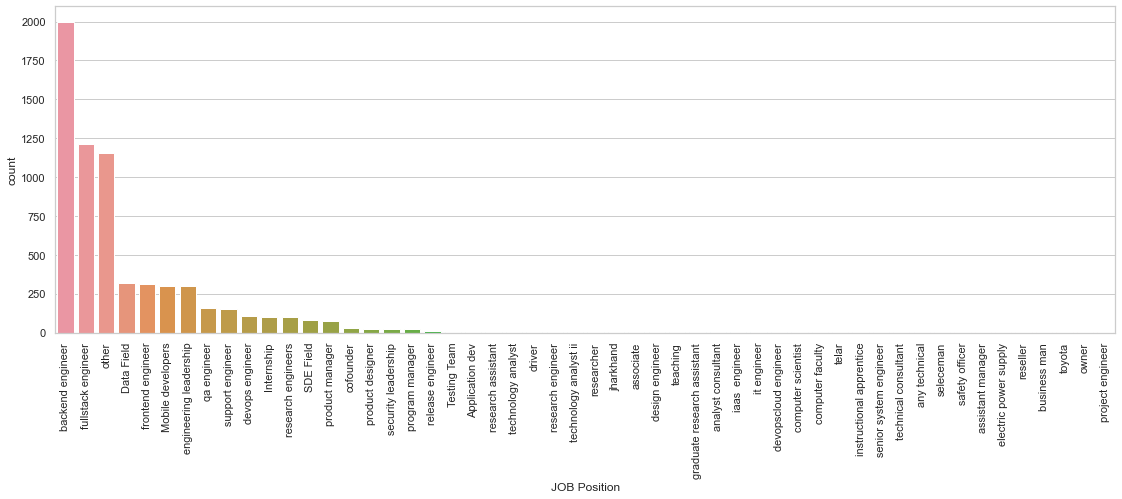

In [46]:
plt.figure(figsize=(19,6))
sns.barplot(x=job_position_count.index,y=job_position_count.values)
plt.xticks(rotation=90)
plt.ylabel("count")
plt.xlabel("JOB Position")
plt.show()

`Inference`:
    
    we can put all unique (occurs only ony time in our dataset) job_position into single bucket "other"

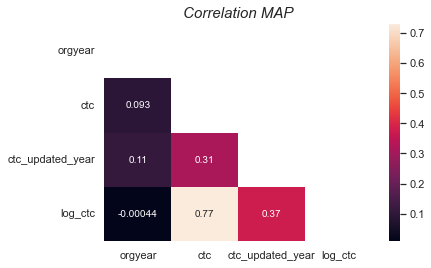

In [47]:
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(
    data=df.corr(),
    annot=True,
    robust=True,
    mask=mask
)
plt.title("Correlation MAP",fontsize="15",fontstyle="italic")
plt.show()

`Inference`: since log_ctc is derived from ctc feature obviously their correlation is more. so dropping of one feature makes our computation less

`Note`: orgyear has no correlation between ctc

In [48]:
df.drop('log_ctc',axis=1,inplace=True)

**Creating NEW FEATURE called YEAR_OF_EXPERIENCE**

In [49]:
year = date.today().year
df['year_of_exp'] = year - df.orgyear

In [50]:
df = df.loc[( (df.year_of_exp>-1) & (~df.year_of_exp.isna())  )]

`Inference`: there is **NO NULL and negative values** are present

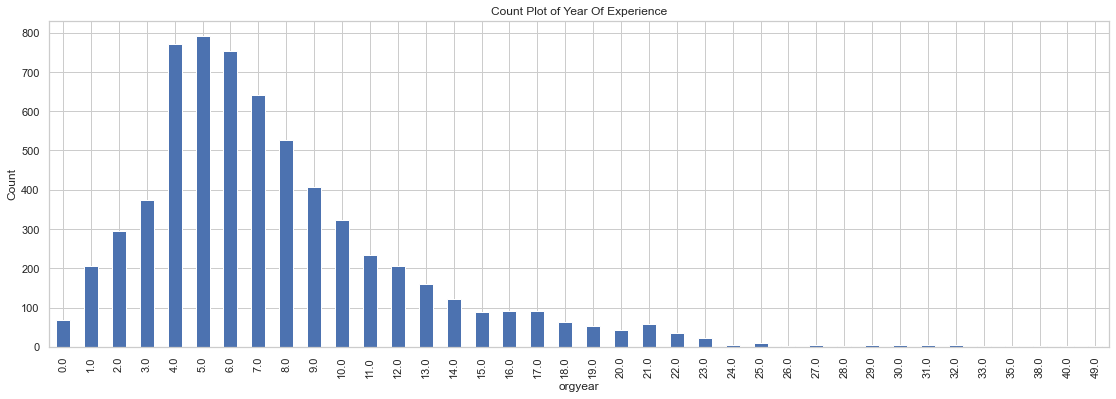

In [51]:
plt.figure(figsize=(19,6))
df.year_of_exp.value_counts(dropna=False).sort_index().plot(kind="bar")
plt.xlabel("orgyear")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Count Plot of Year Of Experience",fontweight=15,fontsize="large")
plt.show()

`Inference:` most of people works on 4 to 6 years or Organization either it's might be Unicorn or Startup

### Creation of NEW Features like **class**

In [52]:
df.groupby(['job_position','company_hash'])['ctc'].describe() 

count         mean          std  \
job_position          company_hash                                              
Application dev       fgqpavj                   1.0      85000.0          NaN   
                      gqvwrt                    1.0   16700000.0          NaN   
                      qvphntz                   2.0      69500.0  6363.961031   
Data Field            aaw                       1.0      88555.0          NaN   
                      adw ntwyzgrgsj            1.0  100000000.0          NaN   
...                                             ...          ...          ...   
technical consultant  zgn vuurxwvmrt vwwghzn    1.0       2000.0          NaN   
technology analyst    xzegojo                   2.0      77500.0  6363.961031   
technology analyst ii ntrho                     1.0      60000.0          NaN   
telar                 shrlvq bvzoyhqx           1.0  100000000.0          NaN   
toyota                otre tburgjta             1.0   10000000.0          NaN   

                                                      min          25%  \
job_position          company_hash                                       
Application dev       fgqpavj                     85000.0      85000.0   
                      gqvwrt                   16700000.0   16700000.0   
                      qvphntz                     65000.0      67250.0   
Data Field            aaw                         88555.0      88555.0   
                      adw ntwyzgrgsj          100000000.0  100000000.0   
...                                                   ...          ...   
technical consultant  zgn vuurxwvmrt vwwghzn       2000.0       2000.0   
technology analyst    xzegojo                     73000.0      75250.0   
technology analyst ii ntrho                       60000.0      60000.0   
telar                 shrlvq bvzoyhqx         100000000.0  100000000.0   
toyota                otre tburgjta            10000000.0   10000000.0   

                                                      50%          75%  \
job_position          company_hash                                       
Application dev       fgqpavj                     85000.0      85000.0   
                      gqvwrt                   16700000.0   16700000.0   
                      qvphntz                     69500.0      71750.0   
Data Field            aaw                         88555.0      88555.0   
                      adw ntwyzgrgsj          100000000.0  100000000.0   
...                                                   ...          ...   
technical consultant  zgn vuurxwvmrt vwwghzn       2000.0       2000.0   
technology analyst    xzegojo                     77500.0      79750.0   
technology analyst ii ntrho                       60000.0      60000.0   
telar                 shrlvq bvzoyhqx         100000000.0  100000000.0   
toyota                otre tburgjta            10000000.0   10000000.0   

                                                      max  
job_position          company_hash                         
Application dev       fgqpavj                     85000.0  
                      gqvwrt                   16700000.0  
                      qvphntz                     74000.0  
Data Field            aaw                         88555.0  
                      adw ntwyzgrgsj          100000000.0  
...                                                   ...  
technical consultant  zgn vuurxwvmrt vwwghzn       2000.0  
technology analyst    xzegojo                     82000.0  
technology analyst ii ntrho                       60000.0  
telar                 shrlvq bvzoyhqx         100000000.0  
toyota                otre tburgjta            10000000.0  

[4205 rows x 8 columns]

In [53]:
groupby_comp_job = df.groupby(['job_position','company_hash'])['ctc'].describe() 

In [54]:
df = df.merge(groupby_comp_job, on=['job_position','company_hash'],how='left')
df

,company_hash,orgyear,ctc,job_position,ctc_updated_year,year_of_exp,count,mean,std,min,25%,50%,75%,max
0,evzzxt bvt,2006.0,11800000,qa engineer,2019.0,16.0,1.0,1.180000e+07,NaN,11800000.0,11800000.0,11800000.0,11800000.0,11800000.0
1,wqgoogctq egq fgqp,2004.0,60000,Mobile developers,2019.0,18.0,2.0,6.000000e+04,0.000000e+00,60000.0,60000.0,60000.0,60000.0,60000.0
2,vqsxrad,2009.0,20000,backend engineer,2019.0,13.0,1.0,2.000000e+04,NaN,20000.0,20000.0,20000.0,20000.0,20000.0
3,oxburjyq ogrhnxgzo rru,2017.0,200000000,support engineer,2020.0,5.0,1.0,2.000000e+08,NaN,200000000.0,200000000.0,200000000.0,200000000.0,200000000.0
4,txzegwyxuo,2015.0,8000,qa engineer,2019.0,7.0,2.0,8.000000e+03,0.000000e+00,8000.0,8000.0,8000.0,8000.0,8000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6464,zvz,2018.0,67300000,backend engineer,2017.0,4.0,48.0,1.653691e+07,4.081696e+07,1000.0,33750.0,75000.0,90000.0,200000000.0
6465,jvzatd,2018.0,2000,backend engineer,2017.0,4.0,12.0,4.633333e+04,2.309795e+04,2000.0,37000.0,46000.0,60250.0,80000.0
6466,xzegojo,2017.0,60000,fullstack engineer,2017.0,5.0,49.0,4.888164e+07,7.423453e+07,3250.0,6000.0,87000.0,100000000.0,200000000.0
6467,ywr ntwyzgrgsxto,2008.0,55000,backend engineer,2017.0,14.0,13.0,4.564641e+07,6.721278e+07,3300.0,10000.0,85000.0,100000000.0,200000000.0


**making an assumption that people works on one company is not same as other even they do same job**

note: It will fail when ctc is unique and ℝ

In [55]:
@np.vectorize
def create_designation(ctcs,quantile1,quantile2,quantile3):
    #print(type(ctcs),type(quantile1),type(quantile2),type(quantile3))
    if(ctcs<quantile1):
        return 0           
    elif(ctcs<quantile2):
        return 1
    elif(ctcs<quantile3):
        return 2
    else:
        return 3           

In [56]:
df['class'] = create_designation(df['ctc'],df['25%'],df['50%'],df['75%'])

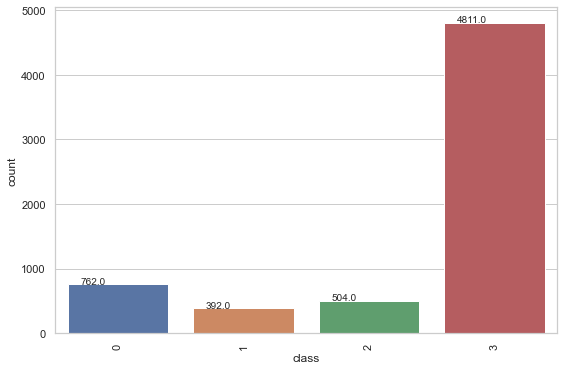

In [57]:
plt.figure(figsize=(9,6))
ax = sns.countplot(
    data = df,
    x='class')
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.2))
plt.xticks(rotation=90)
plt.show()

`Inference`: most of peoples are getting ctc more than quantile3

In [58]:
df.drop(axis=1,labels=['std','count','mean','max','min','25%','50%','75%'],inplace=True)

In [59]:
#df.to_csv('clean_data.csv',index=False)

## DATA ANALYSIS

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6469 entries, 0 to 6468
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company_hash      6469 non-null   object 
 1   orgyear           6469 non-null   float64
 2   ctc               6469 non-null   int64  
 3   job_position      6469 non-null   object 
 4   ctc_updated_year  6469 non-null   float64
 5   year_of_exp       6469 non-null   float64
 6   class             6469 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 404.3+ KB


In [61]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company_hash,6469,3213,nvnv wgzohrnvzwj otqcxwto,157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orgyear,6469.0,NaN,NaN,NaN,2014.416757,4.836287,1973.0,2012.0,2016.0,2018.0,2022.0
ctc,6469.0,NaN,NaN,NaN,29044761.460968,55447024.139376,2.0,25000.0,74000.0,19800000.0,200000000.0
job_position,6469,52,backend engineer,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctc_updated_year,6469.0,NaN,NaN,NaN,2019.095223,1.445962,2015.0,2019.0,2019.0,2020.0,2021.0
year_of_exp,6469.0,NaN,NaN,NaN,7.583243,4.836287,0.0,4.0,6.0,10.0,49.0
class,6469.0,NaN,NaN,NaN,2.447519,1.036996,0.0,2.0,3.0,3.0,3.0


### Univarient analysis

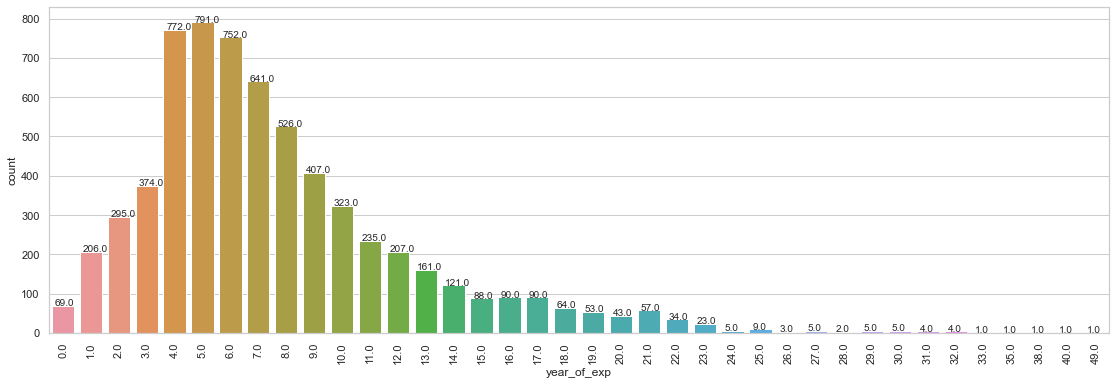

In [62]:
plt.figure(figsize=(19,6))
ax = sns.countplot( data = df,x='year_of_exp')
for p in ax.patches: ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.2))
plt.xticks(rotation=90)
plt.show()

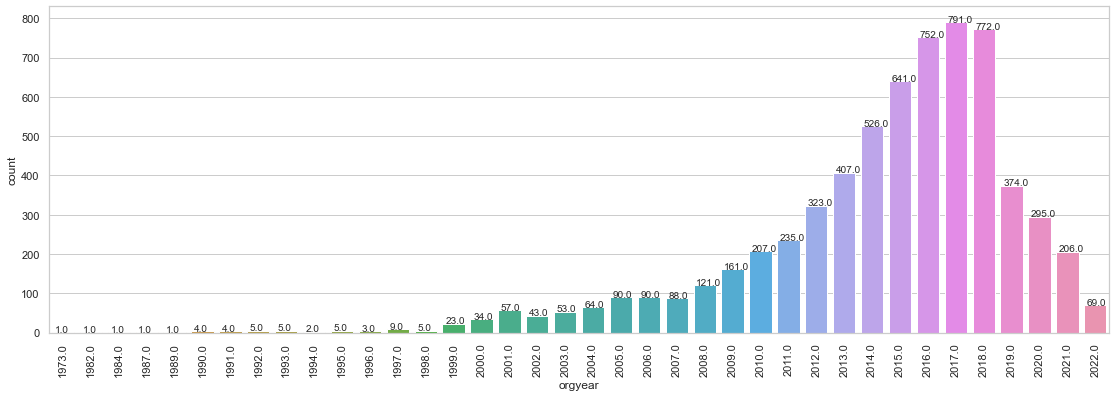

In [63]:
plt.figure(figsize=(19,6))
ax = sns.countplot( data = df,x='orgyear')
for p in ax.patches: ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.2))
plt.xticks(rotation=90)
plt.show()

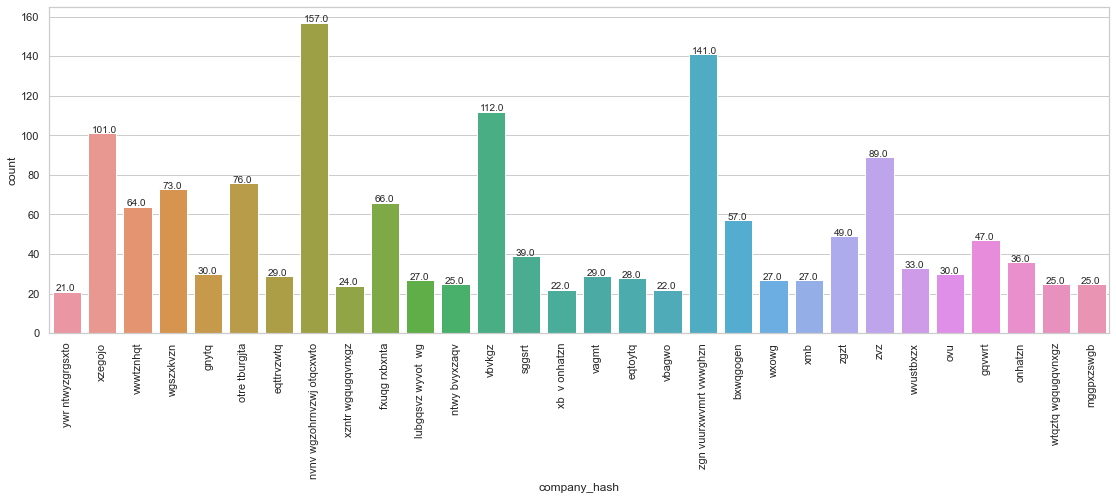

In [64]:
plt.figure(figsize=(19,6))
ax = sns.countplot( data = df.loc[ df.company_hash.isin( 
            df.company_hash.value_counts(dropna=False)[df.company_hash.value_counts(dropna=False).values>20].index)],
        x='company_hash')
for p in ax.patches: ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.2))
plt.xticks(rotation=90)
plt.show()

`inference:`
    
    top companies listed out: nvnv wgzohrnvzwj otqcxwto,zgn vuurxwvmrt vwwghzn,vbvkgz,xzegojo

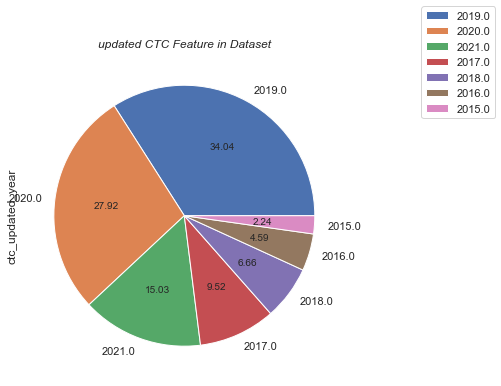

In [65]:
plt.figure(figsize=(9,6))
df['ctc_updated_year'].value_counts(dropna=False).plot(kind='pie',autopct="%0.2f")
plt.legend()
plt.title("updated CTC Feature in Dataset",fontdict={"style":"italic"})
plt.legend(bbox_to_anchor=(1.0,1.0),\
    bbox_transform=plt.gcf().transFigure)
plt.show()

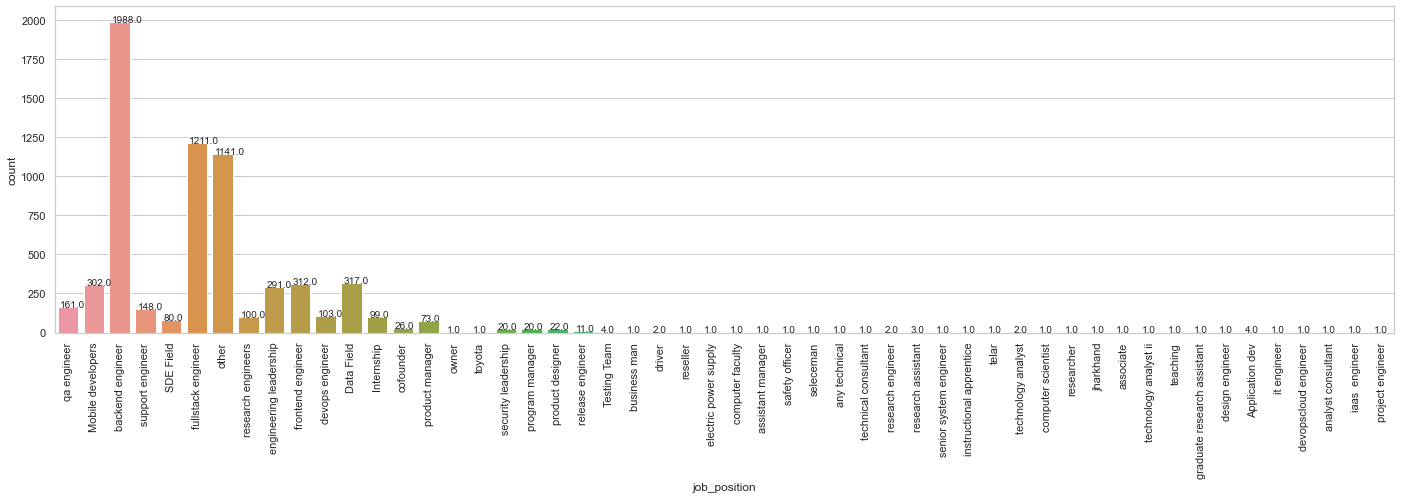

In [66]:
plt.figure(figsize=(24,6))
ax = sns.countplot(df.job_position)
for p in ax.patches: ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.2))
plt.xticks(rotation=90)
plt.show()

`Inference:`
        
        apart from backend and fullstack enginner the Data Field and Mobile developers are going parallely
        
        since we don't have enough information to intercept Other column 

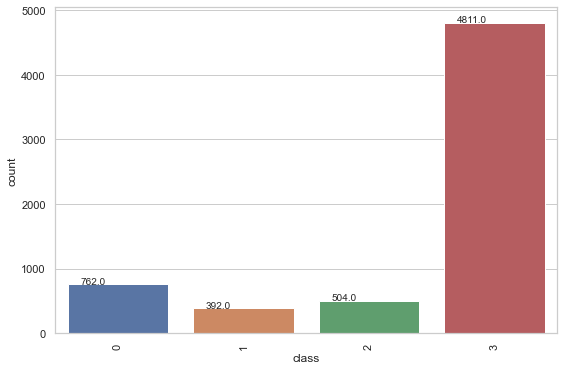

In [67]:
plt.figure(figsize=(9,6))
ax = sns.countplot(
    data = df,
    x='class')
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.2))
plt.xticks(rotation=90)
plt.show()

`Inference:`
    
    most of the people are getting more than second quantile of ctc in their respective job and company. that's good sign

### Bi-varient analysis

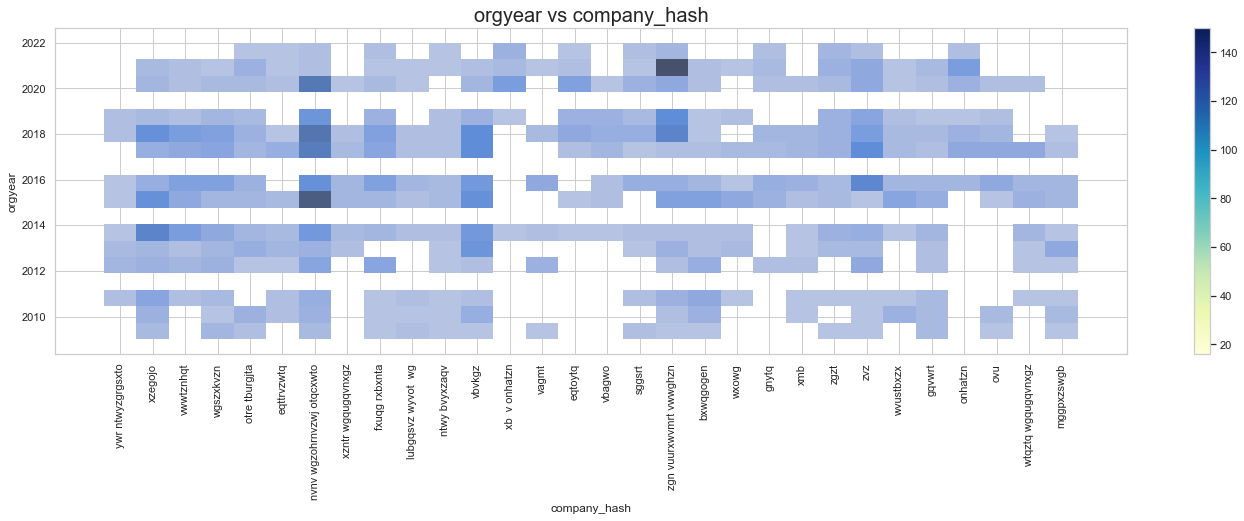

In [68]:
plt.figure(figsize=(24,6))
sns.histplot(
    data= df.loc[(
         (df.company_hash.isin( df.company_hash.value_counts(dropna=False)[df.company_hash.value_counts(dropna=False).values>20].index))
          &
         (df.job_position.isin(['backend engineer', 'fullstack engineer', 'other', 'Data Field','frontend engineer', 'Mobile developers', 'engineering leadership','qa engineer', 'support engineer', 'devops engineer']))
        &
        (df.year_of_exp.isin(list(range(0,14))))
    )],
    x='company_hash',y='orgyear')


norm = mpl.colors.Normalize(  
        df.loc[(
         (df.company_hash.isin( df.company_hash.value_counts(dropna=False)[df.company_hash.value_counts(dropna=False).values>20].index))&(df.job_position.isin(['backend engineer', 'fullstack engineer', 'other', 'Data Field','frontend engineer', 'Mobile developers', 'engineering leadership','qa engineer', 'support engineer', 'devops engineer']))&(df.year_of_exp.isin(list(range(0,14))))
)].groupby('company_hash')['orgyear'].size().min(), 
        df.loc[(
         (df.company_hash.isin( df.company_hash.value_counts(dropna=False)[df.company_hash.value_counts(dropna=False).values>20].index))&(df.job_position.isin(['backend engineer', 'fullstack engineer', 'other', 'Data Field','frontend engineer', 'Mobile developers', 'engineering leadership','qa engineer', 'support engineer', 'devops engineer']))&(df.year_of_exp.isin(list(range(0,14))))
)].groupby('company_hash')['orgyear'].size().max())
plt.xticks(rotation=90)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap='YlGnBu'),)

plt.xticks(rotation=90)
plt.title("orgyear vs company_hash",fontsize=20)
plt.show()

`Inference`: compare to 2010-2014 , 2017 to 2021 have more darker regions

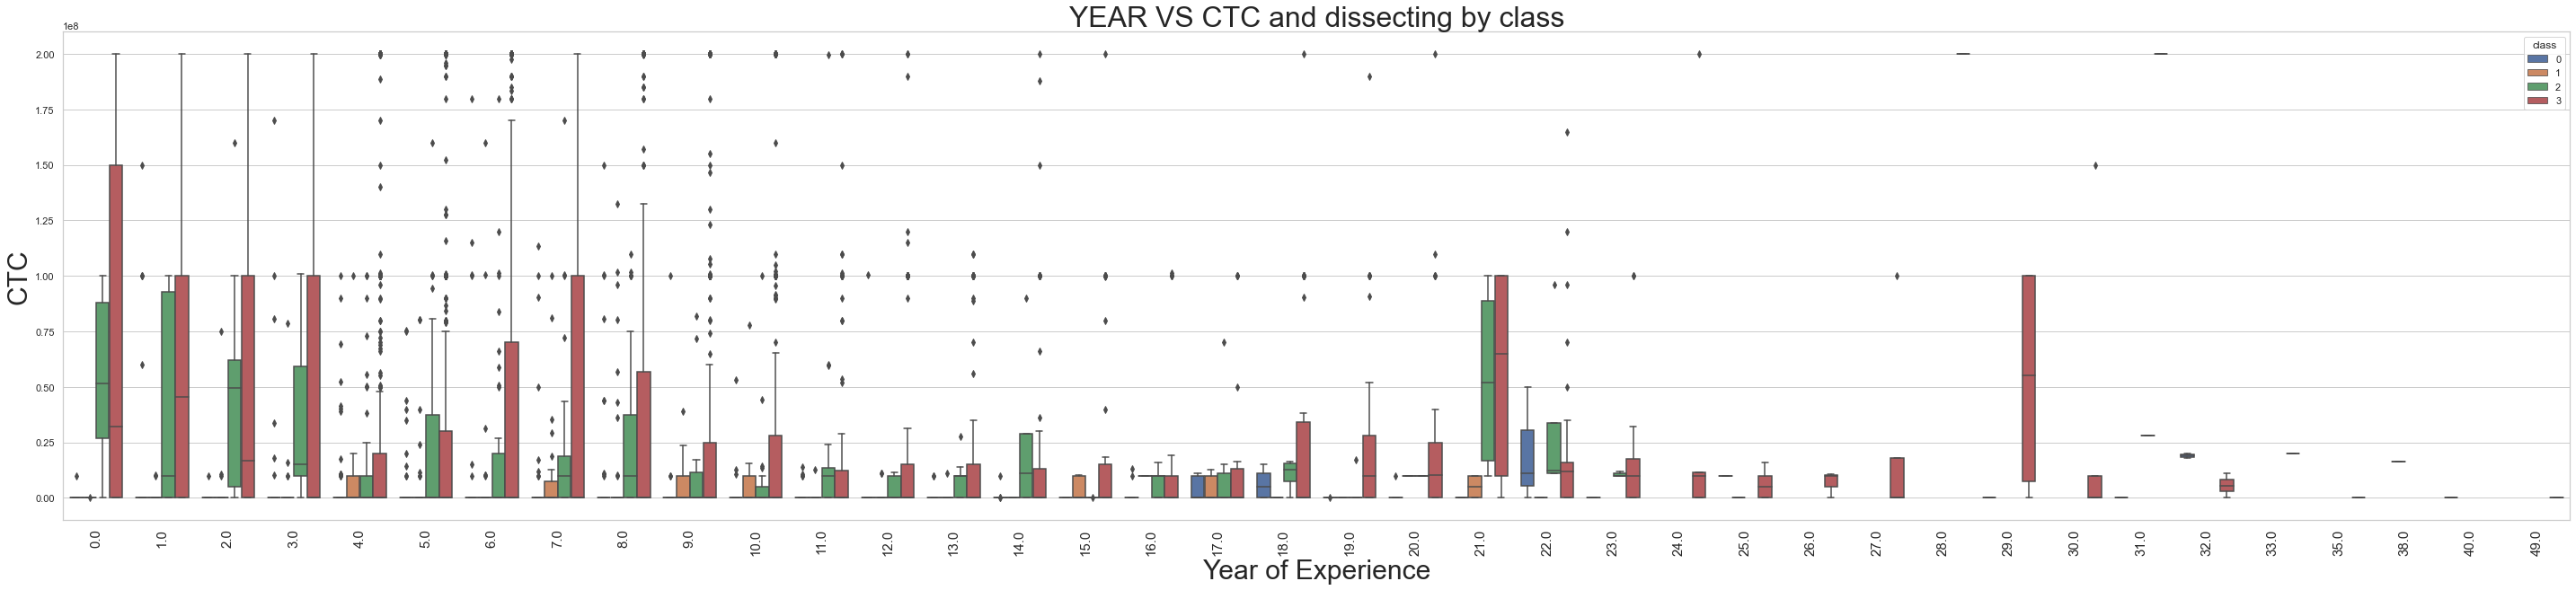

In [69]:
plt.figure(figsize=(50,10))
sns.boxplot(data=df,y='ctc',hue='class',x='year_of_exp')
plt.xticks(fontsize=15,rotation=90)
plt.xlabel("Year of Experience",fontsize=30)
plt.ylabel("CTC",fontsize=30)
plt.title("YEAR VS CTC and dissecting by class",fontsize=32)
plt.show()

`Inference:`

    we notice class 3 peoples are high across all year of experience

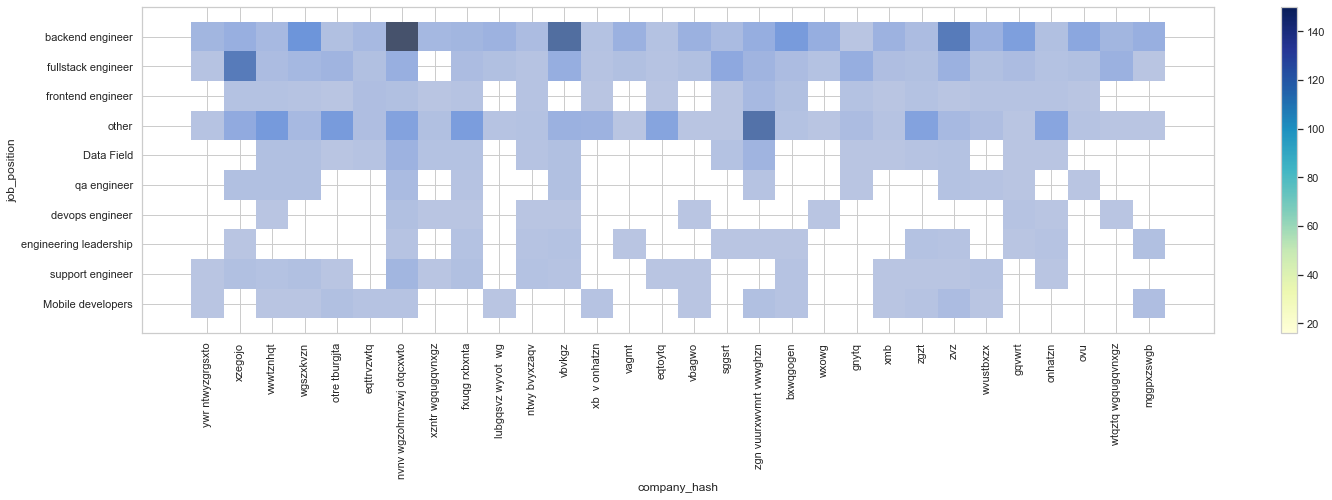

In [70]:
plt.figure(figsize=(24,6))
sns.histplot(
    data= df.loc[(
         (df.company_hash.isin( df.company_hash.value_counts(dropna=False)[df.company_hash.value_counts(dropna=False).values>20].index))
          &
         (df.job_position.isin(['backend engineer', 'fullstack engineer', 'other', 'Data Field','frontend engineer', 'Mobile developers', 'engineering leadership','qa engineer', 'support engineer', 'devops engineer']))
        &
        (df.year_of_exp.isin(list(range(0,14))))
    )],
    x='company_hash',y='job_position')
plt.xticks(rotation=90)

norm = mpl.colors.Normalize(  
        df.loc[(
    (df.company_hash.isin( df.company_hash.value_counts(dropna=False)[df.company_hash.value_counts(dropna=False).values>20].index))&(df.job_position.isin(['backend engineer', 'fullstack engineer', 'other', 'Data Field','frontend engineer', 'Mobile developers', 'engineering leadership','qa engineer', 'support engineer', 'devops engineer']))&(df.year_of_exp.isin(list(range(0,14))))
)].groupby('company_hash')['job_position'].size().min(), 
     df.loc[(
    (df.company_hash.isin( df.company_hash.value_counts(dropna=False)[df.company_hash.value_counts(dropna=False).values>20].index))&(df.job_position.isin(['backend engineer', 'fullstack engineer', 'other', 'Data Field','frontend engineer', 'Mobile developers', 'engineering leadership','qa engineer', 'support engineer', 'devops engineer']))&(df.year_of_exp.isin(list(range(0,14))))
)].groupby('company_hash')['job_position'].size().max())
plt.xticks(rotation=90)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap='YlGnBu'),)

plt.show()

`Inference:` Hot-spot represent more jobs needs in those company

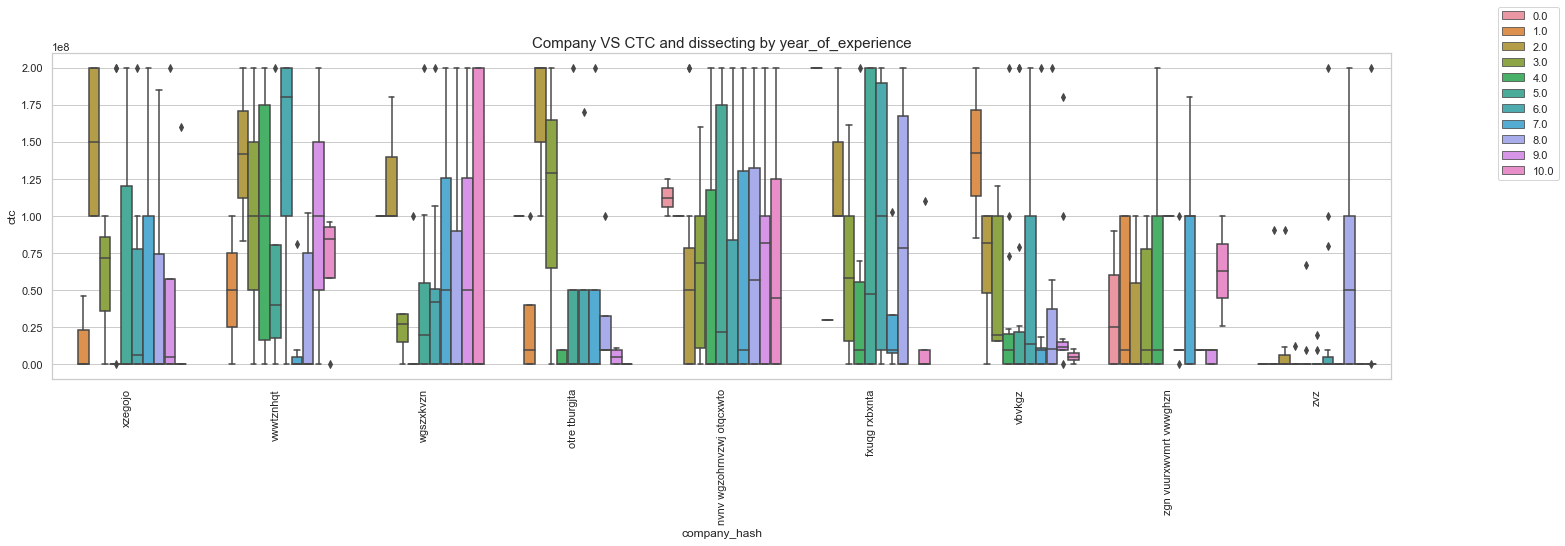

In [71]:
plt.figure(figsize=(24,6))
sns.boxplot(
    data= df.loc[(
         (df.company_hash.isin( df.company_hash.value_counts(dropna=False)[df.company_hash.value_counts(dropna=False).values>60].index))
          &
         (df.job_position.isin(['backend engineer', 'fullstack engineer', 'other', 'Data Field','frontend engineer', 'Mobile developers', 'engineering leadership','qa engineer', 'support engineer', 'devops engineer']))
          &
        (df.year_of_exp.isin(list(range(0,11))))
    )],
    x='company_hash',
    y='ctc',
    hue='year_of_exp',
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.0,1.0),bbox_transform=plt.gcf().transFigure)
plt.title("Company VS CTC and dissecting by year_of_experience",fontsize=15)
plt.show()

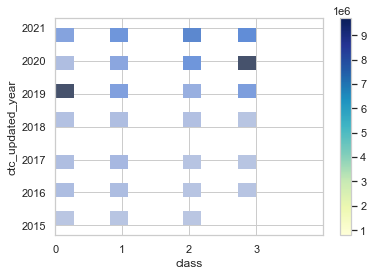

In [72]:
sns.histplot(
    data=df.loc[(
         (df.company_hash.isin( df.company_hash.value_counts(dropna=False)[df.company_hash.value_counts(dropna=False).values>60].index))
          &
         (df.job_position.isin(['backend engineer', 'fullstack engineer', 'other', 'Data Field','frontend engineer', 'Mobile developers', 'engineering leadership','qa engineer', 'support engineer', 'devops engineer']))
          &
        (df.year_of_exp.isin(list(range(0,11))))
    )],
    x='class',
    y='ctc_updated_year',
)
plt.xlim(0,4)


norm = mpl.colors.Normalize(df.groupby('class')['ctc_updated_year'].sum().min(), df.groupby('class')['ctc_updated_year'].sum().max())
plt.xticks(ticks=[0,1,2,3],label=[1,2,3,4])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap='YlGnBu'),)

plt.show()

`Inference`: Plot shows number of peoples who updated ctc w.r.t class. and number of people who updated ctc before 2018 is very low

### Multivarient analysis

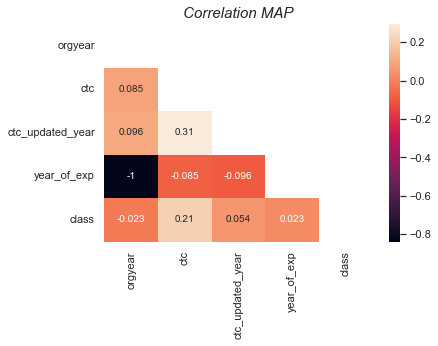

In [73]:
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(
    data=df.corr(),
    annot=True,
    robust=True,
    mask=mask
)
plt.title("Correlation MAP",fontsize="15",fontstyle="italic")
plt.show()

In [74]:
df.drop('year_of_exp',axis=1,inplace=True)

`NOTE:` Correlation doesn't tell causation. but we derived year_of_exp from orgyear might be the reason as well

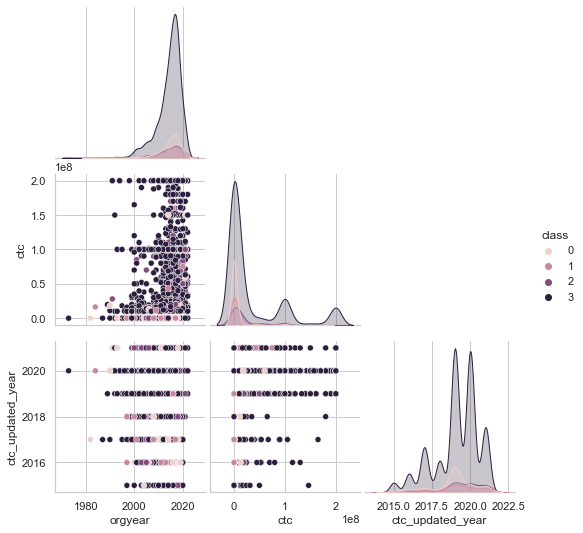

In [75]:
plt.show(24,24)
sns.pairplot(df,corner=True,hue='class')
plt.show()

# Modelling (Unsupervised)

### KMeans 
1. Check Clustering Tendency 
2. elbow method etc for checking fair number of clusters
3. Do kmeans clustering 

### Hierarchial clustering

In [76]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
#from sklearn.pipeline import make_pipeline
#from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder,OneHotEncoder
#from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score,roc_curve, precision_recall_curve,auc,accuracy_score,classification_report,recall_score,precision_score

from pyclustertend import hopkins 
from sklearn.cluster import KMeans 
from kmodes.kmodes import KModes
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [77]:
df.info(
    memory_usage=True,
    verbose=True,
    null_counts=True
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6469 entries, 0 to 6468
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company_hash      6469 non-null   object 
 1   orgyear           6469 non-null   float64
 2   ctc               6469 non-null   int64  
 3   job_position      6469 non-null   object 
 4   ctc_updated_year  6469 non-null   float64
 5   class             6469 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 611.8+ KB


In [78]:
for i in df.select_dtypes(np.object_).columns: df[i]=df[i].astype('category')

`Note`: we can't pass object data-type to ML model. so somehow convert into logically relevant numbers. Pros and Cons


<!-- #OneHotEncoder: make it sparse matrix here. model performance will decrease when we go for higher dimensions and Interpretation will be questionable  -->

TargetEncoder:  

It'll make sure most repetation of values get higher possibilty to occur. like normal Curve

Here I assume Target is ctc ε ℝ. so probabiltiy of getting new job-position is very low and questionable

<!-- #LabelEncoder:  well mathematically we can assign values to new numbers aka values but interpretation agian questionable -->

<!-- feel free try to any -->

In [79]:
Objs_df = df.select_dtypes('category')
Objs_df.sample(5)

,company_hash,job_position
2888,whqqtzn,other
5368,atvrtq tuqgwtoo,fullstack engineer
1196,ogwxn szqvrt,Data Field
983,apvnxv,fullstack engineer
365,nb sqghu ge wgbuvzxto,program manager


In [80]:
encoder = TargetEncoder(verbose=1)  
encoder.fit(Objs_df,df['ctc'])
encoder

TargetEncoder(cols=['company_hash', 'job_position'], verbose=1)

In [81]:
encode_df = df.copy(deep=True)
encode_df[['company_hash','job_position']] = encoder.transform(Objs_df)

In [82]:
scaler = StandardScaler()
scaler.fit(encode_df)

pd.DataFrame(
    [scaler.scale_,scaler.var_],
    columns=df.columns,
    index=['mean','var']
)

,company_hash,orgyear,ctc,job_position,ctc_updated_year,class
mean,2.117487e+07,4.835914,5.544274e+07,1.596614e+07,1.445851,1.036916
var,4.483752e+14,23.386060,3.073897e+15,2.549175e+14,2.090484,1.075194


In [83]:
scaled_df = scaler.transform(encode_df)

scaled_df = pd.DataFrame( scaled_df, columns=df.columns )
scaled_df.shape

(6469, 6)

#### cluster tendency

It tells data follows uniform distribution or not. returns scale between [0,1]  Higher the hopkins score higher the uniform distribution of data.

If Hopkins score is closer to 0, it means good clustering can be achieved with the dataset.

In [84]:
hops=hopkins(scaled_df,6000)
print(hops)

0.07646154735093702


$$Dunn Index=\frac{maximum - distance - Sum of Squares - within - cluster }{ minimum - distance - sum of squares - between - cluster}$$

Inertia tells within cluster sum of square

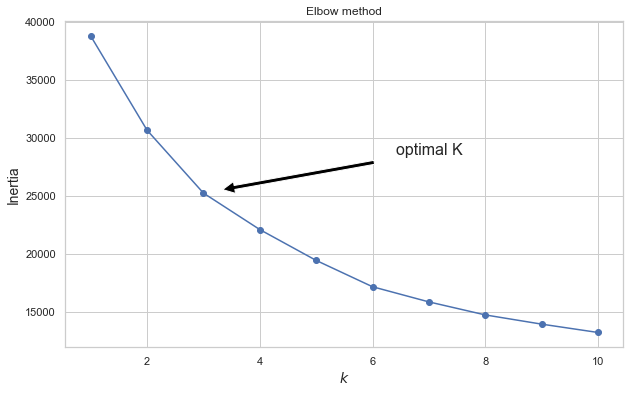

In [85]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42,verbose=0).fit(scaled_df) for k in range(1,11)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(10,6))
plt.plot(range(1,11),inertias,"bo-")
plt.xlabel("$k$",fontsize=14)
plt.ylabel("Inertia",fontsize=14)
plt.annotate('optimal K',
            xy=(3,inertias[2]),
            xytext=(0.55,0.55),
            textcoords='figure fraction',
            fontsize=16,
            arrowprops=dict(facecolor='black',
            shrink=0.1))
plt.title("Elbow method")
plt.show()

`Inference:`

    Higher the K Within sum-of-square distance is less. with make more affinity towards noise.
    
    We found Inflaction point of Cluster 3

In [86]:
kmeans = KMeans(n_clusters=3,init='k-means++',verbose=0,n_jobs=-1) 
kmeans.fit(scaled_df)
kmeans

KMeans(n_clusters=3, n_jobs=-1)

In [87]:
kmeans.cluster_centers_

array([[ 0.86269495,  0.2351272 ,  1.63593033,  0.75537943,  0.70434591,
         0.38361122],
       [ 0.1364098 ,  0.04104527, -0.46937759, -0.09617824, -0.16089816,
        -2.03378752],
       [-0.32679393, -0.0901572 , -0.41454331, -0.22538312, -0.19008786,
         0.44487647]])

we can't interept the clusters now

In [88]:
scaled_df['clusters']= kmeans.fit_predict(scaled_df)

In [89]:
scaled_df.groupby('clusters').median()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,class
clusters,,,,,,
0,0.332828,0.327393,1.279793,1.153414,0.625775,0.532812
1,-0.014486,0.120607,-0.522697,-0.658097,-0.065860,0.532812
2,0.091321,0.327393,-0.523419,-0.658097,-0.065860,-2.360383


In [90]:
melt_df = pd.melt(
    scaled_df.groupby('clusters').median().reset_index(),
    id_vars='clusters'
)

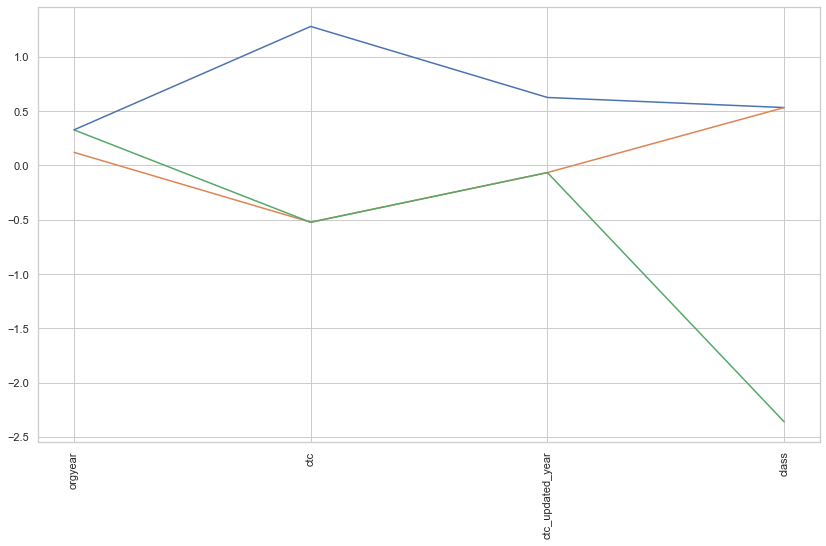

In [91]:
plt.figure(figsize=(14,8))
plt.plot(scaled_df.groupby('clusters').median().drop(['company_hash','job_position'],axis=1).T)
plt.xticks(rotation=90)
plt.show()

In [92]:
fig = px.line_polar( melt_df, r="value", theta="variable", color="clusters",line_close=True,width=900,height=700)
fig.write_image('fig1.png')
#fig.show()

<img src="fig1.png" width="800" height="800"></img>

# `Inference:` Three Clusters found

- cluster 2  might be students in scaler (high orgyear, high ctc_updated_year, low ctc and low class)

- cluster 0 graduates placed high reputed companies (high orgyear, w.r.t high ctc)

- cluster 1 graduates who placed Startups and Unicorns (less orgyear but class is same as cluster 0)

`Note`: company_hash and job_position has no direct interpretation

In [93]:
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 10, verbose=0,n_jobs=-1,max_iter=100)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)

Text(0.5, 1.0, 'Elbow method')

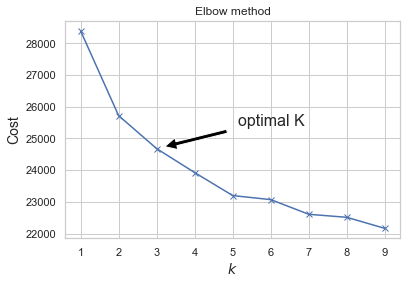

In [94]:
plt.plot(K, cost, 'bx-')
plt.xlabel("$k$",fontsize=14)
plt.ylabel("Cost",fontsize=14)
plt.annotate('optimal K',
            xy=(3,cost[2]),
            xytext=(0.55,0.55),
            textcoords='figure fraction',
            fontsize=16,
            arrowprops=dict(facecolor='black',
            shrink=0.1))
plt.title("Elbow method")

In [95]:
# Huang - chooose data point as centroid
kmode = KModes(n_clusters=3, init = "Huang", n_init = 10, verbose=0,n_jobs=-1,max_iter=200,random_state=1)
clusters = kmode.fit_predict(df)

### **Cluster Centroid**

In [96]:
centroids_ = pd.DataFrame(kmode.cluster_centroids_,columns=df.columns)
centroids_

,company_hash,orgyear,ctc,job_position,ctc_updated_year,class
0,zgn vuurxwvmrt vwwghzn,2016.0,100000000,other,2020.0,3
1,xzegojo,2017.0,50000,fullstack engineer,2019.0,3
2,nvnv wgzohrnvzwj otqcxwto,2018.0,10000000,backend engineer,2019.0,3


In [97]:
agg_ = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')

y_pred = agg_.fit_predict(scaled_df.drop('clusters',axis=1))

scaled_df['clusters'] = y_pred

In [98]:
scaled_df.groupby('clusters').median()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,class
clusters,,,,,,
0,-0.014486,0.120607,-0.522607,-0.658097,-0.065860,0.532812
1,0.444121,0.327393,2.722723,1.564227,0.625775,0.532812
2,0.332828,0.327393,-0.523238,-0.658097,-0.065860,-2.360383


In [99]:
melt_df = pd.melt(
    scaled_df.drop(['company_hash','job_position'],axis=1).groupby('clusters').median().reset_index(),
    id_vars='clusters'
)

fig = px.line_polar( melt_df, r="value", theta="variable", color="clusters",line_close=True,width=900,height=700)
#fig.show()
fig.write_image('fig2.png')

<img src="fig2.png" width="800" height="800"></img>

`Note` In hierarchy based clustering we won't do hard assignment. We pick number of cluster 3

In [100]:
scaled_df.groupby('clusters').median().drop(['company_hash','job_position'],axis=1)

,orgyear,ctc,ctc_updated_year,class
clusters,,,,
0,0.120607,-0.522607,-0.065860,0.532812
1,0.327393,2.722723,0.625775,0.532812
2,0.327393,-0.523238,-0.065860,-2.360383


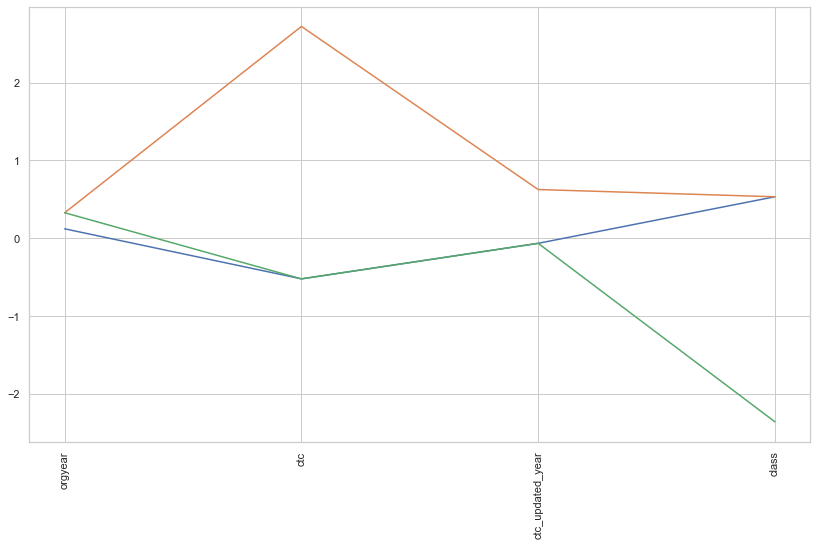

In [101]:
plt.figure(figsize=(14,8))
plt.plot(scaled_df.groupby('clusters').median().drop(['company_hash','job_position'],axis=1).T)
plt.xticks(rotation=90)
plt.show()

# collective Inference:

- email be unique to the person which tends to make every data point as cluster as unique

- orgyear has no correlation between ctc. i.e) even startsup/unicorn also pays you decent amount and most of people works/placed on 4 to 6 years or Organization

- people are getting ctc more than above average in their respecitive company and job designation


- companies where 
```
        nvnv wgzohrnvzwj otqcxwto especially designation for backend engineer
        xzegojo especially designation for fullstack engineer
        zgn vuurxwvmrt vwwghzn 
        vbvkgz,
```
   are recruiting scaler student more


- more placed students are backend enginner, full stack engineer, parallely mobile dev, data field are growing

- students were placed after 2016 more than students were in before 2015 year significantly increased

- class 3 peoples are highly present across all year of experience


 Three Clusters found
```
cluster 2 might be students in scaler (high orgyear, high ctc_updated_year, low ctc and low class)
cluster 1 graduates who placed Startups and Unicorns (less orgyear but class is same as cluster 0)
cluster 0 graduates placed high reputed companies (high orgyear, w.r.t high ctc)
```